<a href="https://colab.research.google.com/github/LJ1201/MSDS-490-Bank_Campaign/blob/main/BankMkting_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import packages

In [1]:
# !pip install gower

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering algorithm
from sklearn.cluster import AgglomerativeClustering

# Rand Index
from sklearn.metrics.cluster import rand_score

# Encode labels
from sklearn import preprocessing


import gower

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import dataset

Data Source: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


##Attribute Information:

Input variables:

#Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')



Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)


17 - cons.price.idx: consumer price index - monthly indicator (numeric)


18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)


19 - euribor3m: euribor 3 month rate - daily indicator (numeric)


20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):


21 - y - has the client subscribed a term deposit? (binary: 'yes','no')




#Relevant Papers:

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS. [bank.zip]



In [3]:
url = 'https://raw.githubusercontent.com/LJ1201/MSDS-490-Bank_Campaign/main/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

In [4]:
data_full = data.copy()
data_full = data.drop(['duration'],axis = 1)

In [5]:
np.random.seed(42)

In [6]:
# data_full_yes = data_full[data_full['y'] == 'yes']
# data_full_yes = data_full_yes.reset_index()

In [7]:
# data_full_yes= data_full_yes.drop(['index'], axis = 1)

In [8]:
# target = data_full_yes[['y']]
# data_no_target = data_full_yes.drop(['y'],axis=1)
# data_no_target.head()

In [9]:
target = data_full[['y']]
data_no_target = data_full.drop(['y'],axis=1)
data_no_target.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [10]:
data_no_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [11]:
data_no_target.nunique()

age                78
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           42
pdays              27
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         316
nr.employed        11
dtype: int64

In [12]:
data_no_target_trans = data_no_target.copy()

##Numeric Variables Transform

Age

In [13]:
data_no_target_trans['age'] = data_no_target_trans['age']//10

In [14]:
data_no_target_trans.nunique()

age                 9
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           42
pdays              27
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         316
nr.employed        11
dtype: int64

In [15]:
data_no_target_trans.head().T

,0,1,2,3,4
age,5,5,3,4,5
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


Campaign

In [16]:
for i in range(0, len(data_no_target_trans)):
  if data_no_target_trans['campaign'][i] > 10:
    data_no_target_trans['campaign'][i] = 11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Pdays into Pweeks

In [17]:
data_no_target_trans['pweeks'] =data_no_target_trans['pdays']

In [18]:
for i in range(0, len(data_no_target_trans)):
  if data_no_target_trans['pweeks'][i] <=28:
    data_no_target_trans['pweeks'][i] = data_no_target_trans['pweeks'][i] // 7
  elif data_no_target_trans['pweeks'][i] >28:
    data_no_target_trans['pweeks'][i] = 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
data_no_target_trans = data_no_target_trans.drop(['pdays'], axis = 1)

euribor3m - euribor 3 month rate

In [20]:
for i in range(0,len(data_no_target_trans)):
  if (data_no_target_trans['euribor3m'][i] >= 0) & (data_no_target_trans['euribor3m'][i] < 1) :
    data_no_target_trans['euribor3m'][i] ='0 - 1'
  elif (data_no_target_trans['euribor3m'][i] > 1 ) and (data_no_target_trans['euribor3m'][i] < 2) :
    data_no_target_trans['euribor3m'][i] ='1 - 2'
  elif (data_no_target_trans['euribor3m'][i] >= 2) and (data_no_target_trans['euribor3m'][i] < 3) :
    data_no_target_trans['euribor3m'][i] ='2 - 3'
  elif (data_no_target_trans['euribor3m'][i] >= 3) and (data_no_target_trans['euribor3m'][i] < 4) :
    data_no_target_trans['euribor3m'][i] ='3 - 4'
  elif (data_no_target_trans['euribor3m'][i] >= 4) :
    data_no_target_trans['euribor3m'][i] ='> 5'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


cons.price.idx

In [21]:
for i in range(0,len(data_no_target_trans)):
  if (data_no_target_trans['cons.price.idx'][i] >= 92) & (data_no_target_trans['cons.price.idx'][i] < 93) :
    data_no_target_trans['cons.price.idx'][i] = '92 - 93'
  elif (data_no_target_trans['cons.price.idx'][i] >= 93 ) and (data_no_target_trans['cons.price.idx'][i] < 94) :
    data_no_target_trans['cons.price.idx'][i] ='93 - 94'
  elif (data_no_target_trans['cons.price.idx'][i] >= 94) :
    data_no_target_trans['cons.price.idx'][i] ='over 94'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


cons.conf.idx

In [22]:
for i in range(0,len(data_no_target_trans)):
  if (data_no_target_trans['cons.conf.idx'][i] >= 40)  :
    data_no_target_trans['cons.conf.idx'][i] = 'over 40'
  elif (data_no_target_trans['cons.conf.idx'][i] <40 ) :
    data_no_target_trans['cons.conf.idx'][i] ='less than 40'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [23]:
data_no_target_trans.nunique()

age                9
job               12
marital            4
education          8
default            3
housing            3
loan               3
contact            2
month             10
day_of_week        5
campaign          11
previous           8
poutcome           3
emp.var.rate      10
cons.price.idx     3
cons.conf.idx      1
euribor3m          5
nr.employed       11
pweeks             5
dtype: int64

In [24]:
data_no_target_trans_test = data_no_target_trans.copy()

In [25]:
data_no_target_trans_test.shape

(41188, 19)

In [ ]:
distance_matrix = gower.gower_matrix(data_no_target_trans_test)

distance_matrix

In [76]:
encoder = preprocessing.LabelEncoder()

encoded_target = target.apply(encoder.fit_transform)

print(f'in this encoding, {encoded_target.iloc[0].values} represents {target.iloc[0].values}')

labels = pd.DataFrame()
labels['target'] = encoded_target.values.reshape(1, -1).tolist()[0]

in this encoding, [0] represents ['yes']


In [77]:
model_complete = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='precomputed')
clusters_complete = model_complete.fit_predict(distance_matrix)

In [78]:
labels['complete-predictions'] = clusters_complete

In [79]:
cri = rand_score(encoded_target.values.reshape(1, -1)[0], clusters_complete)
print(f'Rand Index: {cri}')

Rand Index: 0.5894927563163881


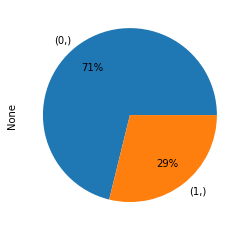

In [80]:
labels[['complete-predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

In [81]:
labels.value_counts(["target", "complete-predictions"])

target  complete-predictions
0       0                       3302
        1                       1338
dtype: int64

In [82]:
labels['aligned-clusters'] = labels['complete-predictions'].apply(lambda x: int(not x))

In [83]:
labels.value_counts(["target", "aligned-clusters"])

target  aligned-clusters
0       1                   3302
        0                   1338
dtype: int64

Text(0.5, 15.0, 'Predicted Labels')

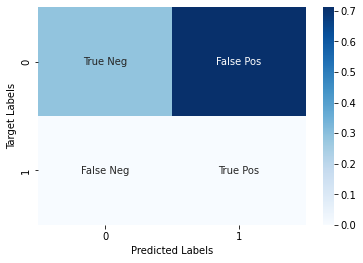

In [84]:
cf_matrix = confusion_matrix(encoded_target.values.reshape(1, -1)[0], labels[["aligned-clusters"]].values.reshape(1, -1)[0])
cf_labels = ['True Neg','False Pos','False Neg','True Pos']
cf_labels = np.asarray(cf_labels).reshape(2,2)
fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=cf_labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')    
ax.set_xlabel('Predicted Labels')

##EDA

In [ ]:
data.info()

##Categroical Variables

Categorical variables needs to be transformed into a form the model would take in. One hot encoding is a common way to perform the task

In [ ]:
objList = []

for i in data.dtypes.index :
    if i =='y':continue
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if data.dtypes[i] in (["object"]) : objList.append( i )


In [ ]:
objList

In [ ]:
data.columns

In [ ]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [ ]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

In [ ]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

In [ ]:
data_1.columns

### Data Transformation - V1 (Agreed on Team Discussion)

In [ ]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [ ]:
df_tran_1.columns

In [ ]:
df_tran_1.head().T

In [ ]:
df_tran_1.y.value_counts()

In [ ]:
df_tran_1.columns

In [ ]:
df_tran_1.head().T

In [ ]:
df_tran_1.info()

In [ ]:
df_tran_1.dtypes.index

In [ ]:
objList = []

for i in df_tran_1.dtypes.index :
    if i =='y':continue
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if df_tran_1.dtypes[i] in (["object"]) : objList.append( i )

for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df_tran_1[i], prefix=thePrefix, drop_first=False )   
    df_tran_1 = pd.concat( [df_tran_1, y], axis=1 )
    df_tran_1 = df_tran_1.drop( i, axis=1 )

In [ ]:
objList

In [ ]:
df_tran_1.columns

In [ ]:
df_tran_1['y'] = df_tran_1.y.map(dict(yes=1, no=0))

In [ ]:

X = df_tran_1.loc[:, df_tran_1.columns != 'y']
y = df_tran_1.loc[:, df_tran_1.columns == 'y']


os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

In [ ]:
data_final_vars=df_tran_1.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]



logreg = LogisticRegression(solver= 'liblinear')
rfe = RFE(logreg,n_features_to_select=20)
rfe = rfe.fit(os_data_X.values, os_data_y.values.ravel())

features = list(os_data_X.columns[rfe.support_])

print('total features:', os_data_X.shape[1])

print(rfe.support_)
print(features)
print(rfe.ranking_)

##Fit Model

##Model 1

Logistic Regression with top 20 selected by Recursive Feature Elimination method

In [ ]:
features

In [ ]:
X = os_data_X[features]
y = os_data_y['y']

In [ ]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
cm_1 = confusion_matrix(y_test, y_pred)
print(cm_1)

In [ ]:
plot_confusion_matrix(logreg, X_test, y_test)  
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
#define metrics
y_pred_proba_test = logreg.predict_proba(X_test)[::,1]
fpr_test, tpr_test, _ = metrics.roc_curve(y_test,  y_pred_proba_test)
auc_test = metrics.roc_auc_score(y_test, y_pred_proba_test)

y_pred_proba_train = logreg.predict_proba(X_train)[::,1]
fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_pred_proba_train)
auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train)


#create ROC curve
plt.title('Logistic Reg ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % auc_test, color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot([0, 1], [0,1], 'r--')
plt.ylim([0, 1])
plt.show()
plt.show()

###Model 2

In [ ]:
features

In [ ]:
features_2 = features.copy()

features_2.remove('z_marital_divorced')

features_2.remove('z_marital_unknown')

# features_2.remove('z_edu_new_post_high')

In [ ]:
X = os_data_X[features_2]
y = os_data_y['y']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=21)
logreg_2 = LogisticRegression()
logreg_2.fit(X_train_2, y_train_2)


In [ ]:
y_pred_2 = logreg_2.predict(X_test_2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_2.score(X_test_2, y_test_2)))

In [ ]:
cm_2 = confusion_matrix(y_test_2, y_pred_2)
print(cm_2)
print(classification_report(y_test_2, y_pred_2))

In [ ]:
#define metrics
y_pred_proba_test = logreg_2.predict_proba(X_test_2)[::,1]
fpr_test, tpr_test, _ = metrics.roc_curve(y_test_2,  y_pred_proba_test)
auc_test = metrics.roc_auc_score(y_test_2, y_pred_proba_test)

y_pred_proba_train = logreg_2.predict_proba(X_train_2)[::,1]
fpr_train, tpr_train, _ = metrics.roc_curve(y_train_2,  y_pred_proba_train)
auc_train = metrics.roc_auc_score(y_train_2, y_pred_proba_train)


#create ROC curve
plt.title('Logistic Reg 2 ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % auc_test, color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot([0, 1], [0,1], 'r--')
plt.ylim([0, 1])
plt.show()
plt.show()

##Test on Original data excluding oversampling data points using Logistic regression model

In [ ]:
df_tran_1

In [ ]:
After_test_X = df_tran_1[features]
After_test_Y = df_tran_1['y']

In [ ]:
y_pred_3 = logreg.predict(After_test_X)

In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(After_test_X, After_test_Y)))